# Motion Statistical Analysis
Analyzes video clips for frame to frame motion and bins the severity of motion into a histogram.

Iterate over test set and safe duv into dataframe.

- Create test loader
- Load homography estimation model from configs

In [1]:
import os
import cv2
import pandas as pd
import torch
from dotmap import DotMap
from torch.utils.data import DataLoader
from kornia import tensor_to_image, warp_perspective

import lightning_modules
from datasets import VideoDataset
from utils.io import load_yaml, load_pickle, save_pickle, scan2df, natural_keys
from utils.transforms import anyDictListToCompose
from utils.processing import image_edges, four_point_homography_to_matrix, frame_pairs
from utils.viz import yt_alpha_blend

# iterate over test set and safe duv into dataframe
server = 'local'
servers = load_yaml('../configs/servers.yml')
server = DotMap(servers[server])

configs = 'predictive_horizon_dgx.yml'
configs = load_yaml(os.path.join(server.configs.location, configs))

backbone_path = 'deep_image_homography_estimation_backbone/version_2'

# append configs by backbone
backbone_configs = load_yaml(os.path.join(server.logging.location, backbone_path, 'configs.yml'))
df = scan2df(os.path.join(server.logging.location, backbone_path, 'checkpoints'), '.ckpt')
ckpts = sorted(list(df.file), key=natural_keys)
configs['model']['homography_regression'] = {
    'lightning_module': backbone_configs['lightning_module'],
    'model': backbone_configs['model'],
    'path': backbone_path,
    'checkpoint': 'checkpoints/{}'.format(ckpts[-1]),
    'experiment': backbone_configs['experiment']
}

configs = DotMap(configs)

meta_df = pd.read_pickle(os.path.join(server.configs.location, configs.data.meta_df))[configs.data.subset_length:configs.data.subset_length+2]
meta_df.train = False  # artificially set to test set
test_meta_df = meta_df[meta_df.train == False]
test_video_paths = [os.path.join(server.database.location, row.database, row.file['path'], row.file['name']) for _, row in test_meta_df.iterrows()]
test_pre_transforms = [anyDictListToCompose(row.pre_transforms) for _, row in test_meta_df.iterrows()]
test_aug_transforms = [anyDictListToCompose(row.aug_transforms) for _, row in test_meta_df.iterrows()]

# load video meta data if existing, returns None if none existent
test_metadata = load_pickle(os.path.join(configs.data.test_metadata))
if test_metadata is not None:
    if len(test_metadata['video_paths']) == 0:
        test_metadata = None

# create video dataset and dataloader
clip_length_in_frames = 8
frame_rate = 5
frames_between_clips = clip_length_in_frames - 1
precomputed_metadata = test_metadata
num_workers = 8
pre_transforms = test_pre_transforms
aug_transforms = test_aug_transforms
seeds = True

vid_ds = VideoDataset(
    video_paths=test_video_paths,
    clip_length_in_frames=clip_length_in_frames,
    frames_between_clips=frames_between_clips,
    frame_rate=frame_rate,
    precomputed_metadata=test_metadata,
    num_workers=num_workers,
    pre_transforms=pre_transforms,
    aug_transforms=aug_transforms,
    seeds=seeds
)

# save metadata
if test_metadata is None:
    save_pickle(os.path.join(configs.data.test_metadata), vid_ds.metadata)

batch_size = 2
drop_last = True

vid_dl = DataLoader(
    vid_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=drop_last
)

# load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print('Running on {}'.format(device))
torch.set_grad_enabled(False)
homography_regression = getattr(lightning_modules, configs.model.homography_regression.lightning_module).load_from_checkpoint(
    checkpoint_path=os.path.join(server.logging.location, configs.model.homography_regression.path, configs.model.homography_regression.checkpoint),
    **configs.model
)
homography_regression.to(device).eval()

# run inference and log duvs with corresponding vid and frame index
log_df = pd.DataFrame(columns=['vid_idx', 'clip_idx', 'duv', 'uv', 'H'])

log_df.attrs = {
    'clip_length_in_frames': clip_length_in_frames,
    'frame_rate': frame_rate,
    'frames_between_clips': frames_between_clips,
    'meta_data': vid_ds.metadata
}

cnt = 0

for batch_idx, batch in enumerate(vid_dl):
    vids, aug_vids, re_sample_frame_rates, frame_rates, vid_idc, clip_idc = batch
    print('\rBatch: {}/{}, BxNxCxHxW: {}, Video/Frame Idices: {}/{}'.format(batch_idx + 1, len(vid_dl), list(vids.shape), vid_idc.numpy().tolist(), clip_idc.numpy().tolist()), end='')

    vids = vids.to(device)

    frames_i, frames_ips = frame_pairs(vids, 1)

    frames_i   = frames_i.reshape((-1,) + frames_i.shape[-3:])      # BxNxCxHxW -> B*NxCxHxW
    frames_ips = frames_ips.reshape((-1,) + frames_ips.shape[-3:])  # BxNxCxHxW -> B*NxCxHxW
    duvs = homography_regression(frames_i, frames_ips)

    frames_i   = frames_i.view((batch_size,-1,) + frames_i.shape[-3:])      # B*NxCxHxW -> BxNxCxHxW
    frames_ips = frames_ips.view((batch_size,-1,) + frames_ips.shape[-3:])  # B*NxCxHxW -> BxNxCxHxW

    duvs = duvs.view(batch_size, -1, 4, 2)  # reshape B*Nx4x2 -> BxNx4x2

    # iterate batch
    for sample_idx in range(batch_size):
        uvs = image_edges(frames_i[sample_idx])     
        Hs = four_point_homography_to_matrix(uvs, duvs[sample_idx])

        # iterate sequence
        for duv, uv, H in zip(duvs[sample_idx], uvs, Hs):
            log = {
                'vid_idx': vid_idc[sample_idx].cpu().item(),
                'clip_idx': clip_idc[sample_idx].cpu().item(),
                'duv': duv.cpu().numpy(),
                'uv': uv.cpu().numpy(),
                'H': H.cpu().numpy()
            }
            
            log_df = log_df.append(log, ignore_index=True)

#         # viz
#         wrps = warp_perspective(frames_i[sample_idx], torch.inverse(Hs), frames_i.shape[-2:])
#         blends = yt_alpha_blend(frames_ips[sample_idx], wrps)

#         for blend in blends:
#             cv2.imshow('blend', tensor_to_image(blend))
#             cv2.waitKey()

# cv2.destroyAllWindows()

# log results
log_df.to_pickle('frame_to_frame_homography_regression.pkl')
log_df


Running on cuda
Batch: 201/1544, BxNxCxHxW: [2, 8, 3, 480, 640], Video/Frame Idices: [0, 0]/[400, 401]

,vid_idx,frame_idx,duv,uv,H,duv_mpd,duv_mpd_ravg
0,0,-29,"[[-0.63305354, -51.418804], [-5.2502813, -49.4...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.9926386, 0.012520448, -51.418804], [-0.007...",52.509964,NaN
1,0,-28,"[[11.82735, -28.18468], [-48.13101, -75.38363]...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.76816016, -0.015212218, -28.18468], [-0.08...",55.174629,NaN
2,0,-27,"[[-20.056984, -58.727463], [-33.844296, -32.16...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.98983526, 0.0150446175, -58.727463], [-0.0...",58.130753,NaN
3,0,-26,"[[13.416806, 2.247427], [9.857112, -3.912341],...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.9857057, -0.007051472, 2.247427], [-0.0056...",16.127398,NaN
4,0,-25,"[[7.818106, -9.507159], [7.150587, -9.788372],...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[1.0133835, -0.0101012075, -9.507159], [-0.00...",19.278854,NaN
...,...,...,...,...,...,...,...
21611,1,21582,"[[27.209906, 7.1819496], [7.4067707, -29.72147...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.90006816, -0.00920988, 7.1819496], [-0.031...",31.122540,34.456009
21612,1,21583,"[[29.115387, -25.865858], [45.100376, -5.81658...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[1.028535, 0.09358941, -25.865858], [0.024777...",38.950108,34.879650
21613,1,21584,"[[-1.5831317, -20.255024], [-5.446216, -31.757...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.93707764, 0.019085145, -20.255024], [-0.00...",34.164906,35.238940
21614,1,21585,"[[9.379433, -35.113937], [30.597878, -48.72334...","[[0.0, 0.0], [0.0, 640.0], [480.0, 640.0], [48...","[[0.9155242, 0.040070318, -35.113937], [0.0298...",40.416382,35.346189


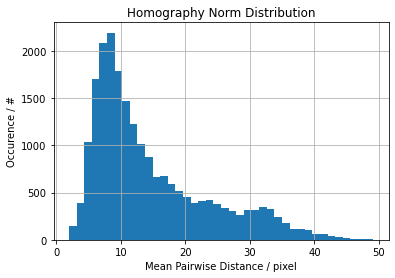

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# generate histogram of the norm of duv
log_df = pd.read_pickle('frame_to_frame_homography_regression.pkl')
log_df['duv_mpd'] = log_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

# running average
window = 30  # corresponds to one second at 5 fps
log_df['duv_mpd_ravg'] = log_df.duv_mpd.rolling(window).mean()
log_df.clip_idx -= window - 1  # adjust frame index to initial frame

hist = log_df.duv_mpd_ravg.hist(bins=40)
hist.set_title('Homography Norm Distribution')
hist.set_xlabel('Mean Pairwise Distance / pixel')
hist.set_ylabel('Occurence / #')
log_df

In [4]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotmap import DotMap
from kornia import tensor_to_image

from datasets import VideoDataset
from utils.io import load_yaml, load_pickle

# sample videos with supposedly little and plenty motion
log_df = pd.read_pickle('frame_to_frame_homography_regression.pkl')
log_df['duv_mpd'] = log_df.duv.apply(lambda x: np.linalg.norm(x, axis=1).mean())

# running average
window = 30  # corresponds to 6 seconds at 5 fps
log_df['duv_mpd_ravg'] = log_df.duv_mpd.rolling(window).mean()
log_df.clip_idx -= window - 1  # adjust frame index to initial frame

# threshold
th1 = 20.
th2 = 20.

weak_motion_df = log_df[log_df.duv_mpd_ravg < th1]
strong_motion_df = log_df[log_df.duv_mpd_ravg > th2]

# randomly sample weak and strong motion clips
n = 10
weak_motion_samples = weak_motion_df.sample(n=n, random_state=42)
strong_motion_samples = strong_motion_df.sample(n=n, random_state=42)

# get configs for video paths
server = 'local'
servers = load_yaml('../configs/servers.yml')
server = DotMap(servers[server])

configs = 'predictive_horizon_dgx.yml'
configs = load_yaml(os.path.join(server.configs.location, configs))
configs = DotMap(configs)

meta_df = pd.read_pickle(os.path.join(server.configs.location, configs.data.meta_df))[configs.data.subset_length:configs.data.subset_length+2]
meta_df.train = False  # artificially set to test set
test_meta_df = meta_df[meta_df.train == False]
test_video_paths = [os.path.join(server.database.location, row.database, row.file['path'], row.file['name']) for _, row in test_meta_df.iterrows()]

# show randomly sampled clips
frame_rate = log_df.attrs['frame_rate']
clip_length_in_frames = window
frames_between_clips = log_df.attrs['frames_between_clips']
num_workers = 8

for (_, weak_motion_sample), (_, strong_motion_sample) in zip(weak_motion_samples.iterrows(), strong_motion_samples.iterrows()):
    print('Loading videos:\n{}\n{}'.format(test_video_paths[weak_motion_sample.vid_idx], test_video_paths[strong_motion_sample.vid_idx]))

    # load video meta data if existing, returns None if none existent
    test_metadata = load_pickle(os.path.join(configs.data.test_metadata))
    if test_metadata is not None:
        if len(test_metadata['video_paths']) == 0:
            test_metadata = None

    vid_ds = VideoDataset(
        video_paths=test_video_paths,
        clip_length_in_frames=clip_length_in_frames,
        frames_between_clips=frames_between_clips,
        precomputed_metadata=test_metadata,
        frame_rate=frame_rate,
        num_workers=num_workers,
        pre_transforms=[None for _ in range(len(test_video_paths))],
        aug_transforms=[None for _ in range(len(test_video_paths))],
        seeds=True
    )

    weak_clip, aug, fr, vid_fps, vid_idx, clip_idx = vid_ds[weak_motion_sample.clip_idx]
    strong_clip, aug, fr, vid_fps, vid_idx, clip_idx = vid_ds[strong_motion_sample.clip_idx]

    for weak_frame, strong_frame in zip(weak_clip, strong_clip):
        weak_frame, strong_frame = tensor_to_image(weak_frame), tensor_to_image(strong_frame)
        cv2.imshow('weak_motion', weak_frame[...,::-1])
        cv2.imshow('strong_motion', strong_frame[...,::-1])
        cv2.waitKey()
cv2.destroyAllWindows()

    # cv2.imshow()

    # frame_rate_scale = int((weak_cap.get(cv2.CAP_PROP_FPS) - 1)/(frame_rate - 1))

    # weak_cap.set(2, int(weak_motion_sample.clip_idx*frame_rate_scale))
    # strong_cap.set(2, int(strong_motion_sample.clip_idx*frame_rate_scale))
    # print(weak_motion_sample.clip_idx, int(weak_motion_sample.clip_idx*frame_rate_scale), weak_cap.get(cv2.CAP_PROP_FRAME_COUNT))

#     for _ in range(25):
#         _, weak_frame = weak_cap.read()
#         _, strong_frame = strong_cap.read()

#         print(weak_frame.shape)
#         cv2.imshow('weak', weak_frame)
#         cv2.waitKey()

#     weak_cap.release()
#     strong_cap.release()

Loading videos:
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video68.mp4
/media/martin/Samsung_T5/data/endoscopic_data/cholec80/videos/video67.mp4
